# Titanic

This notebook is to explore the titanic dataset and produce a machine learning model that can predict which passengers survived or not depending on various features.

# Data preparation

**Option 1:**

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import seaborn as sn
import sqlalchemy
import seaborn as sns
%matplotlib inline

# set chart style
# plt.style.use('ggplot')

# Kaggle submission tools
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# create database engine
engine = sqlalchemy.create_engine(
    url = 'postgresql://danielsuarez-mash@localhost/titanic_project?'
)

train = pd.read_sql('SELECT * FROM train', engine)
test = pd.read_sql('SELECT * FROM test', engine)
eg_submission = pd.read_sql('SELECT * FROM gender_submission', engine)

**Option 2:**

In [3]:
# # download competition data
# api.competition_download_files('titanic')

# # get datasets
# with zipfile.ZipFile(file = 'titanic.zip') as my_zip:
#     with my_zip.open(name = 'train.csv') as train_file:
#         train = pd.read_csv(train_file)
#     with my_zip.open(name = 'test.csv') as test_file:
#         test = pd.read_csv(test_file)
#     with my_zip.open(name = 'gender_submission.csv') as gender_sub:
#         eg_submission = pd.read_csv(gender_sub)

# Exploratory Data Analysis

In [4]:
train_copy = train.copy()
test_copy = test.copy()
train_copy.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,None,S


In [5]:
print(train_copy.info())
print('*'*100)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    float64
 7   parch        891 non-null    float64
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 83.7+ KB
None
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count 

In [6]:
train_copy.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## EDA Objectives

1. What features are useful for helping to predict survival?
2. Are there any data quality issues?
3. Are there any opportunities to engineer new features?

Text(0.5, 0, 'Survived (0 false, 1 true)')

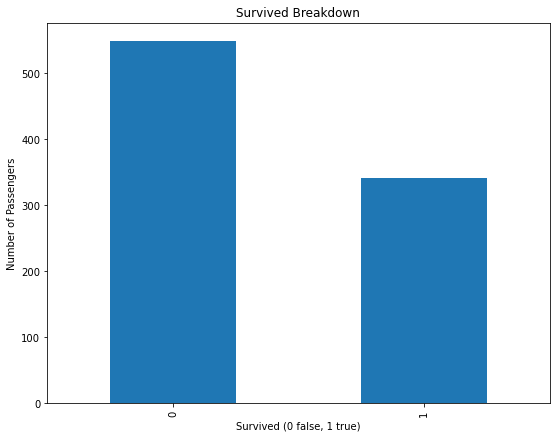

In [7]:
train_copy['survived'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.title('Survived Breakdown')
plt.ylabel('Number of Passengers')
plt.xlabel('Survived (0 false, 1 true)')

## Part 1: What columns are useful for helping to predict survival?

### Pclass (Passenger Class)


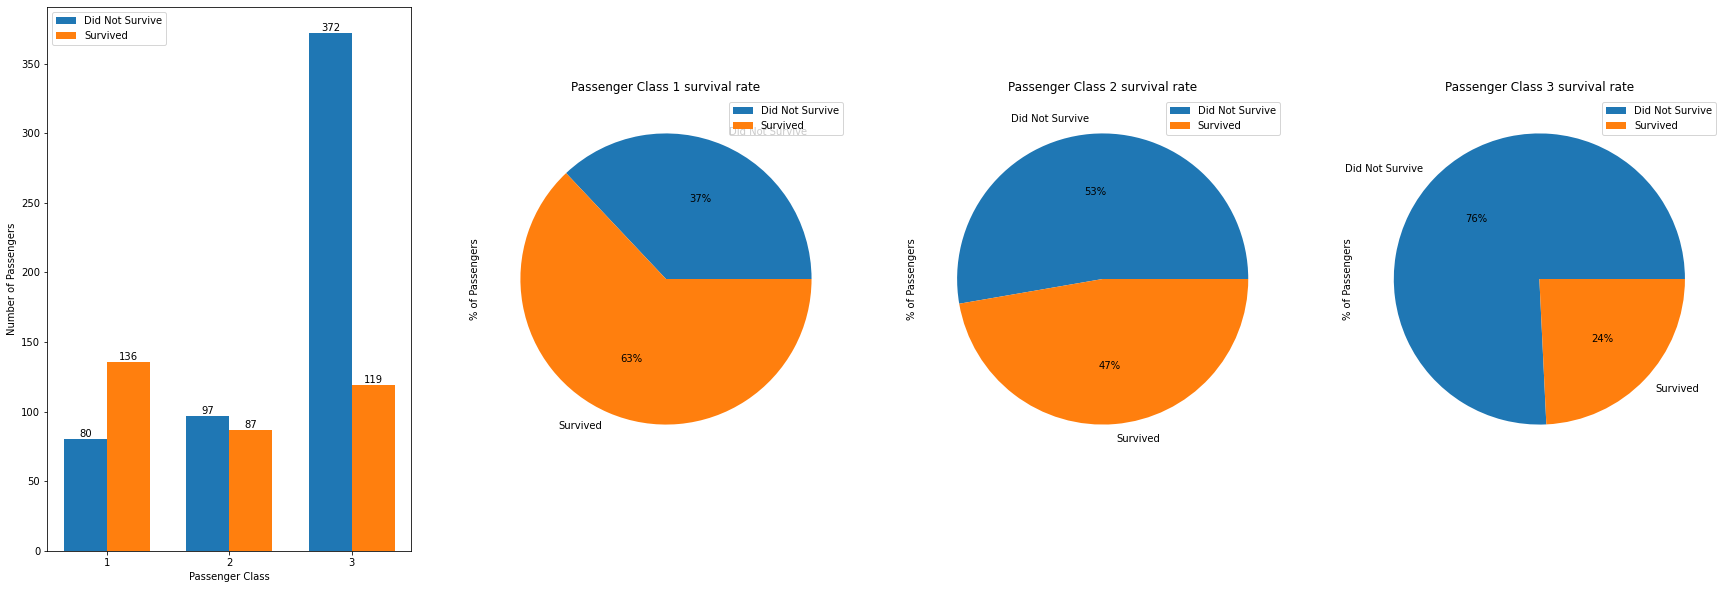

In [8]:
# group by
data = train_copy.groupby(['pclass', 'survived']).passengerid.count().unstack()

# set up figure and axes
figure, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize = (30,10))

####### BAR CHART #######

x = np.array([1, 2, 3]) # set passenger classes as x-axis
width = 0.35 # width of bars

bars_1 = ax.bar(x = x-width/2, height = data[0], width = width, label = 'Did Not Survive') # first set of bars
bars_2 = ax.bar(x = x+width/2, height = data[1], width = width, label = 'Survived') # second set of bars

ax.set_xticks(ticks = x) # make sure only pclasses are shown on x-axes
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Number of Passengers')
ax.bar_label(container=bars_1, labels = data[0]) # label 1st set of bars
ax.bar_label(container=bars_2, labels = data[1]) # label 2nd set of bars
ax.legend()

####### PIE CHARTS ########

# survival rate for pclass 1
pclass1 = train_copy[train_copy['pclass'] == 1].groupby('survived').passengerid.count()
pclass1.plot.pie(ax = ax1, radius=1, autopct='%.0f%%', labels = ['Did Not Survive', 'Survived'])
ax1.set_title('Passenger Class 1 survival rate')
ax1.set_ylabel('% of Passengers')
ax1.legend()

# survival rate for pclass 2
pclass2 = train_copy[train_copy['pclass'] == 2].groupby('survived').passengerid.count()
pclass2.plot.pie(ax = ax2, radius=1, autopct='%.0f%%', labels = ['Did Not Survive', 'Survived'])
ax2.set_title('Passenger Class 2 survival rate')
ax2.set_ylabel('% of Passengers')
ax2.legend()

# survival rate for pclass 3
pclass3 = train_copy[train_copy['pclass'] == 3].groupby('survived').passengerid.count()
pclass3.plot.pie(ax = ax3, radius=1, autopct='%.0f%%', labels = ['Did Not Survive', 'Survived'])
ax3.set_title('Passenger Class 3 survival rate')
ax3.set_ylabel('% of Passengers')
ax3.legend()

1. Is Pclass a good feature we can use to predict survival?

From the charts above, we can see **a large number of passengers in class 3 did not survive**. In fact, the proportion of passengers which survived rises with the class they were in. One assumption we could make then is that wealthier passengers with a 1st class ticket were prioritised in some way during the evacuation. But we should investigate this.

- **Investigate whether there really is an association between passenger class and survival. Or is passenger class a proxy for another more influential factor. For example, were passengers in Pclass 1 higher up on the boat and/or closer to lifeboats?**
 
    
2. Are there any data quality issues with Pclass?

No missing values in both training or testing datasets. ***To interrogate the feature for any incorrect data, we could investigate the fare distribution for each Passenger Class.***

3. Are there any opportunities to data engineer new features?

Passenger Class is a simple categorical feature which no other information which we can extract. However, it will be worth investigating any co-linearities (correlation) with other features. I'm going to suspect that this feature is associated with the fare feature. 

- **Investigate whether pclass is correlated with fare and if there are any opportunities to combine these features together.**

### Name

Names are inherently difficult to analyse given that they are all completely unique. However, there are some similarities between names, in particular: titles. This is something we will explore here.

In [9]:
train_copy['name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: name, Length: 891, dtype: object

In [10]:
# build title column
train_copy['title'] = train_copy['name'].str.split(pat = ',').apply(lambda x: x[1].split('.')[0])
train_copy['title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: title, dtype: int64

In [11]:
# build title column
test_copy['title'] = test_copy['name'].str.split(pat = ',').apply(lambda x: x[1].split('.')[0])
test_copy['title'].value_counts()

 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Ms          1
 Dr          1
 Dona        1
Name: title, dtype: int64

### NEW FEATURE: Title Group

In [12]:
# let's group some titles together
train_copy['title_group'] = train_copy['title']
train_copy['title_group'].replace(to_replace = [' Miss', ' Mlle'], value = 'Unmarried female', inplace = True)
train_copy['title_group'].replace(to_replace = [' Mrs', ' Mme'], value = 'Married female', inplace = True)
train_copy['title_group'].replace(to_replace = [' Master', ' Dr', ' Rev', ' Major', ' Col', ' Don', ' Ms', 
                                                ' Lady', ' Sir', ' Capt', ' the Countess', ' Jonkheer', ' Dona'], 
                                                  value = 'Rare', inplace = True)
train_copy['title_group'].value_counts()

 Mr                 517
Unmarried female    184
Married female      126
Rare                 64
Name: title_group, dtype: int64

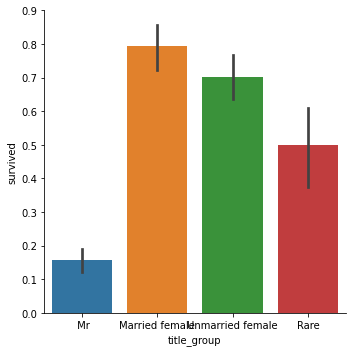

In [13]:
# factorplot
sns.catplot(data = train_copy, x = 'title_group', y = 'survived', kind = 'bar')

***Notes***

Above we learn that married females did have a higher survival rate than unmarried females, which is probably in line with the assumption that there are more married females who are also mothers. Given the stark difference in survival rates, it is a useful feature which would help the ML model determine who survived and who didn't.

### Sex

Text(0, 0.5, '% of Passengers')

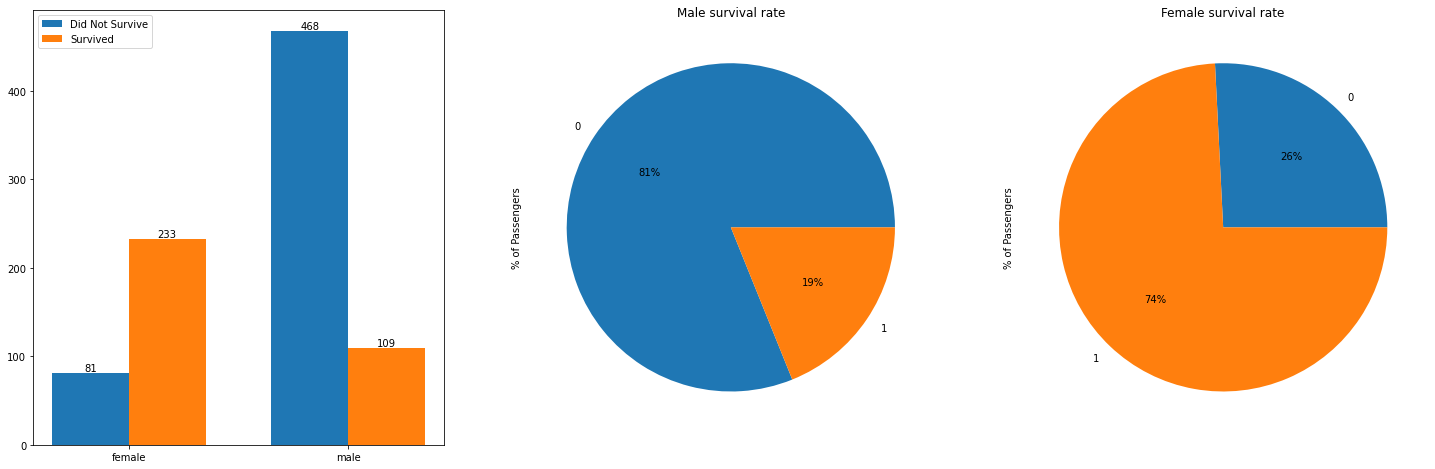

In [14]:
# group by
data = train_copy.groupby(['sex', 'survived']).passengerid.count().unstack()

# set up figure
figure, (ax, ax1, ax2) = plt.subplots(1, 3, figsize = (25,8))

####### BAR CHART #######

x = np.array([0, 1])
width = 0.35

bars_nsrv = ax.bar(x = x-width/2, height = data[0], width = width, label = 'Did Not Survive')
bars_srv = ax.bar(x = x+width/2, height = data[1], width = width, label = 'Survived')
ax.set_xticks(ticks = x, labels = ['female', 'male'])
ax.bar_label(container = bars_nsrv, labels = data[0])
ax.bar_label(container = bars_srv, labels = data[1])
ax.legend()

####### PIE CHARTS #######

# survival rate for pclass 1
male = train_copy[train_copy['sex'] == 'male'].groupby('survived').passengerid.count()
male.plot.pie(ax = ax1, radius=1, autopct='%.0f%%')
ax1.set_title('Male survival rate')
ax1.set_ylabel('% of Passengers')

# survival rate for pclass 2
female = train_copy[train_copy['sex'] == 'female'].groupby('survived').passengerid.count()
female.plot.pie(ax = ax2, radius=1, autopct='%.0f%%')
ax2.set_title('Female survival rate')
ax2.set_ylabel('% of Passengers')

1. Is this a useful feature for helping to predict survival?

Yes, I'm going to assume females were prioritised during the evacuation. However we should investigate this.

- ***We should investigate the female group to see how they make up other features. For example, do they all sit in one age group? Do they all belong to one Passenger Class? Did a lot of them have children?***

2. Are there any data quality issues?

No missing values in either dataset. However, there are less females than males but not by much. It's worth noting that ML models can't learn a pattern from few examples and so we need sufficient amounts of data to allow our ML model to learn. There are sufficient female data points here to not consider any resampling techniques.

3. Are there any opportunities to engineer new features?

Not really. Sex is, again, a simple categorical feature with no extra info we can extract.

### Age

Text(0.5, 0, 'Age Group')

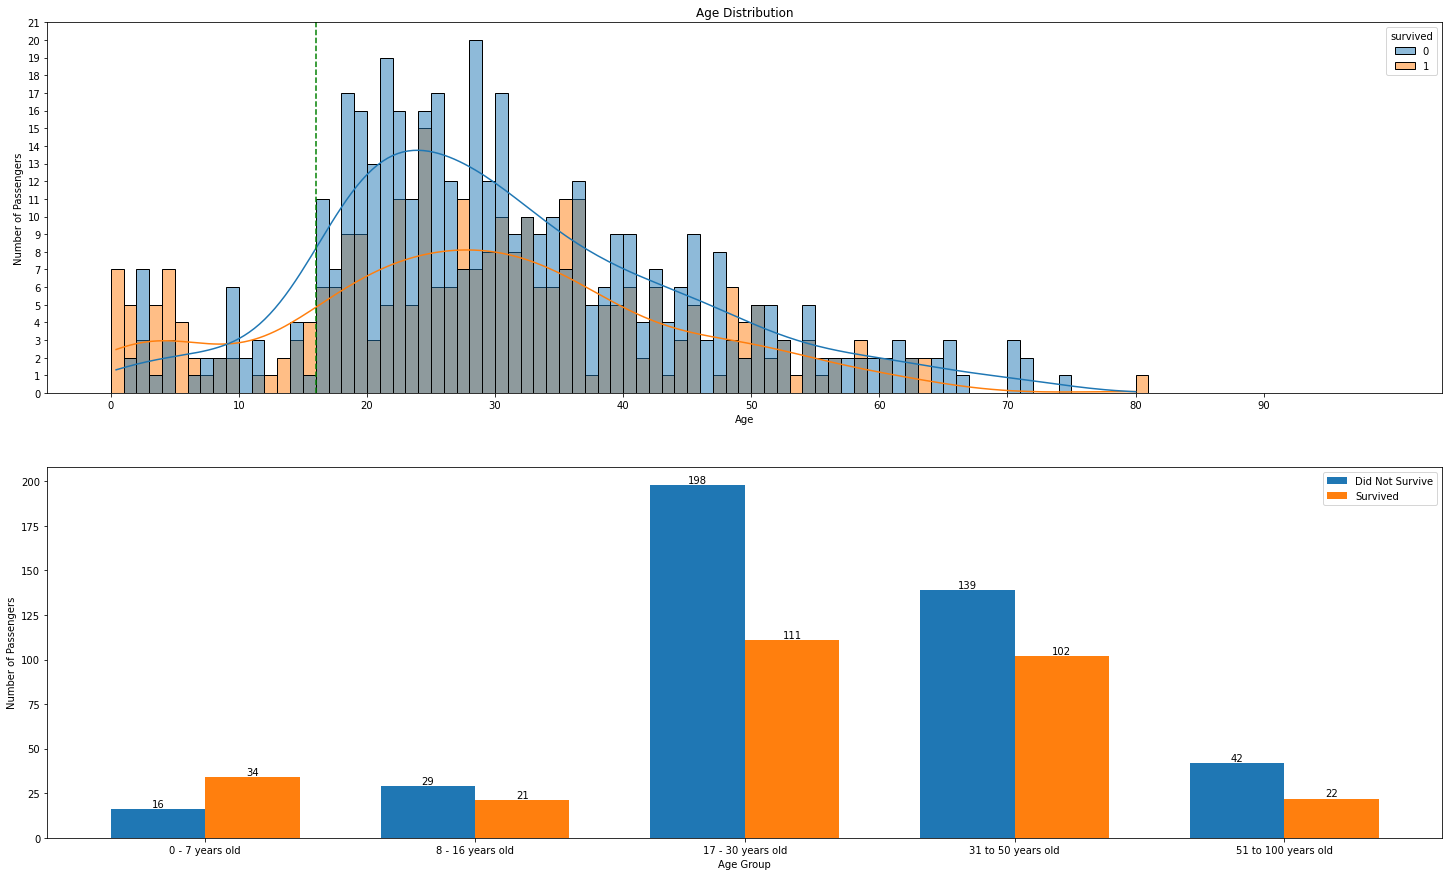

In [15]:
# set up figure
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (25, 15))

# set bins
age_bins = np.arange(start = 0, stop = 100, step = 1)
xticks = np.arange(start = 0, stop = 100, step = 10)
yticks = np.arange(start = 0, stop = 22, step = 1)

######## AGE DISTRIBUTION CHART #########
sns.histplot(data = train_copy, x = 'age', hue = 'survived', kde = True, bins = age_bins, ax = ax1)
ax1.axvline(x = 16, color = 'green', linestyle = '--')
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of Passengers')
ax1.set_xticks(ticks = xticks)
ax1.set_yticks(ticks = yticks);

######## SURVIVAL RATE BY AGE GROUP BAR CHART #########
age_groups = pd.IntervalIndex.from_arrays(left = (0, 7, 16, 30, 50),
                                          right = (7, 16, 30, 50, 100))

x = np.arange(0, 5, 1)

train_copy['age_group'] = pd.cut(x = train_copy['age'], 
                            bins = age_groups, 
                            include_lowest = True)

data = train_copy.groupby(['age_group', 'survived']).passengerid.count().unstack()
not_surv_bar = ax2.bar(x = x-width/2, height = data[0], width = width, label = 'Did Not Survive')
surv_bar = ax2.bar(x = x+width/2, height = data[1], width = width, label = 'Survived')
ax2.legend()
ax2.set_xticks(ticks = [0, 1, 2, 3, 4], labels = ['0 - 7 years old', '8 - 16 years old', '17 - 30 years old', '31 to 50 years old', '51 to 100 years old'])
ax2.bar_label(container = not_surv_bar, labels = data[0])
ax2.bar_label(container = surv_bar, labels = data[1])
ax2.set_ylabel('Number of Passengers')
ax2.set_xlabel('Age Group')

1. Is this a useful feature for helping to predict survival?

Yes, as shown above, children and babies under roughly 16 years old were most likely prioritised and hence saw higher survival rates than any other age group. An even higher proportion of children under 7 years old survived. This is in line with what we would expect from human nature: prioritising the vulnerable and allowing the stronger to take on more risk.  

- ***We should investigate to see whether there are any other reasons for a low survival rate amongst the 17-30 age group other than the fact they are more likely to be 'strong and healthy'. Was this group majority male? Was this group majority in passenger class 3?

2. Are there any data quality issues?

Yes, we have missing values in both datasets but not a huge amount. 

- ***Given that clearly a useful feature for predicting survival, we need to make sure we deal with missing values in the best way possible. If we use the mean to impute missing values and if the mean is in the (15-65) age group then we will be increasing the chance of a 'did not survive' prediction. We should see if the other features can help us determine somebody's age.***

3. Are there any opportunities to engineer new features?

We have already binned passengers into age groups which should summarise survival rates amongst different ages clearly.

### SibSp - Number of siblings/spouses

Text(0.5, 1.0, 'Survived by Number of Siblings/Spouses')

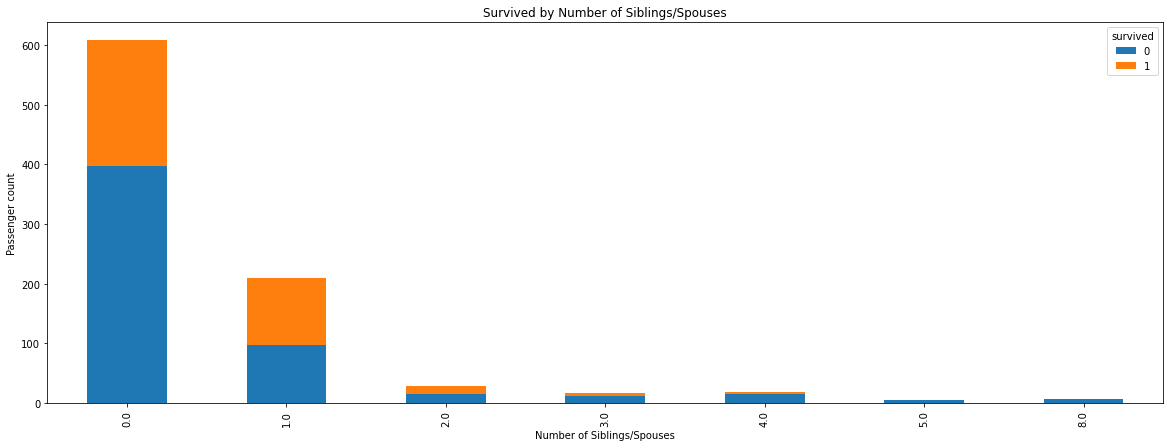

In [16]:
figure, ax1 = plt.subplots(1, figsize = (20, 7))

data = train_copy.groupby(['sibsp', 'survived']).passengerid.count().unstack().plot(kind = 'bar', ax = ax1, stacked = True)
ax1.set_ylabel('Passenger count')
ax1.set_xlabel('Number of Siblings/Spouses')
ax1.set_title('Survived by Number of Siblings/Spouses')

1. Is this a useful predictor for survival?

The majority of passengers did not have any siblings or spouses with them on the Titanic. The survival split in this group is equal to the overall survival split meaning that this group could be a representative sample of passengers onboard the Titanic. 

Just over 50% of those in group 1 survived. The survival rate in group 2 and beyond starts to fall. This pattern might be useful as a predictor for survival. So yes, this feature, with some feature engineering, could be a useful predictor. 

- ***Why does group 0 have a better survival rate than group 1? Were there more males in group 0? Did group 0 contain a more passengers between 15 and 65 years of age? Were there more passengers in Passenger Class 3 in group 0?***
- ***Why do we see such low survival rates among group 3 and beyond? What type of passengers do we see in these groups?***

2. Are there any data quality issues?

No missing data for either dataset. However, there are not many passengers with 3 or more siblings/spouses which might make it hard for an ML model to learn from.

3. Are there any opportunities for feature engineering?

Yes, it might be a good idea to combine this feature with Parch to calculate family size.

### Parch - number of parents/children

Text(0, 0.5, 'Survival Rate')

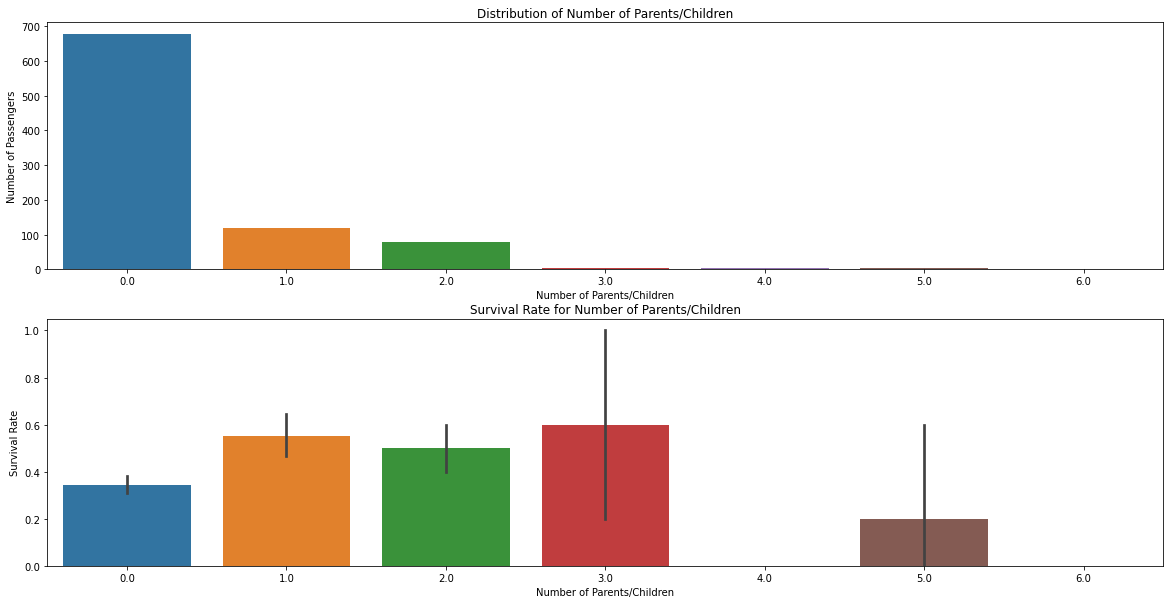

In [17]:
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))

sns.countplot(data = train_copy, x = 'parch', ax = ax1)
ax1.set_ylabel('Number of Passengers')
ax1.set_xlabel('Number of Parents/Children')
ax1.set_title('Distribution of Number of Parents/Children')

sns.barplot(data = train_copy, x = 'parch', y = 'survived', estimator = np.mean, ax = ax2)
ax2.set_title('Survival Rate for Number of Parents/Children')
ax2.set_xlabel('Number of Parents/Children')
ax2.set_ylabel('Survival Rate')

1. Is this a good feature to predict survival?

Similar to SibSp, the majority of passengers do not have any parents or children with them. The survival split in this group is also identical the overall titanic survival split meaning that this group could contain a representative sample of passengers onboard the titanic.

The rate of survival increases in group 1, which is also similar to the SibSp feature. An assumption could be that there are a relatively higher number of mothers and daughters in this category. This might explain why the survival rate decreases for group 2, as this group would contain more fathers. 

- ***Investigate the make up of group 0, 1 and 2. What is the reason behind their difference in survival rate? Did group 1 have a better survival rate because of a combination of gender make up and very young children?***

2. Are there any data quality issues?

No missing values. There is imbalance between groups but not enough to be a concern for machine learning. However, there is a very small amount of passengers with 3 or more parents/children. One would assume that these passengers are parents with 3 or more children, but this needs to be verified.

- ***Verify whether passengers in group 3 and above were all exclusively parents with 3 or more children.***

### NEW FEATURE: Family Size

Text(0.5, 0, 'Family Size')

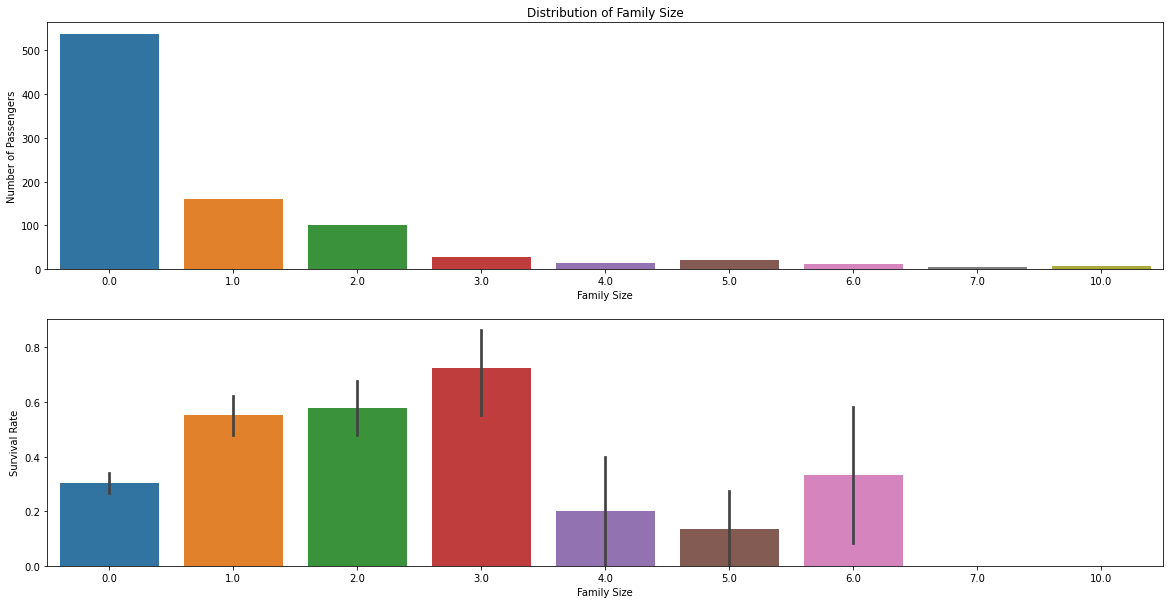

In [18]:
train_copy['family_size'] = train_copy[['sibsp', 'parch']].sum(axis = 1)
fam_size_surv = train_copy.groupby(['family_size', 'survived']).passengerid.count().unstack()
fam_size_surv_rate = fam_size_surv

figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))

sns.countplot(data = train_copy, x = 'family_size', ax = ax1)
ax1.set_ylabel('Number of Passengers')
ax1.set_xlabel('Family Size')
ax1.set_title('Distribution of Family Size')

sns.barplot(data = train_copy, x = 'family_size', y = 'survived', estimator = np.mean, ax = ax2)
ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Family Size')

The chart above suggests move people onboard were travelling alone. This group had a low survival rate which is possibly because there are less mothers and children in this class. It might be useful to see what happens if categorise based on whether passengers were solo or not:

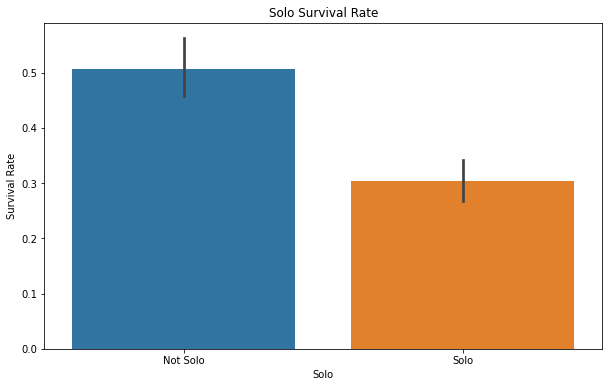

In [19]:
figure, axes = plt.subplots(figsize = (10, 6))

# create solo feature
solo = train_copy['family_size'] == 0
train_copy['solo'] = solo.map(arg = {False: 0, True: 1})

# plot solo survival rate
sns.barplot(data = train_copy, x = 'solo', y = 'survived', ax = axes)
axes.set_title('Solo Survival Rate')
axes.set_xlabel('Solo')
axes.set_ylabel('Survival Rate')
axes.set_xticks(ticks = [0, 1], labels = ['Not Solo', 'Solo'])

### Ticket

In [20]:
train_copy

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,title_group,age_group,family_size,solo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,None,S,Mr,Mr,"(16.0, 30.0]",1.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,Mrs,Married female,"(30.0, 50.0]",1.0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,None,S,Miss,Unmarried female,"(16.0, 30.0]",0.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,Mrs,Married female,"(30.0, 50.0]",1.0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,None,S,Mr,Mr,"(30.0, 50.0]",0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0.0,0.0,211536,13.0000,None,S,Rev,Rare,"(16.0, 30.0]",0.0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S,Miss,Unmarried female,"(16.0, 30.0]",0.0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1.0,2.0,W./C. 6607,23.4500,None,S,Miss,Unmarried female,NaN,3.0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0.0,0.0,111369,30.0000,C148,C,Mr,Mr,"(16.0, 30.0]",0.0,1


As shown above, this feature is a little more tricky than previous ones. From what we can see above, it appears as though ticket strings are made up of an initial code followed by a number. Some tickets have a code and some don't. ***Let's check how many parts make up a ticket string.***

In [21]:
# copy the dataset
train_copy = train_copy.copy()

# split the ticket into parts
train_copy['ticket_split'] = train_copy['ticket'].str.split(' ')

# how many parts do we get?
number_of_parts = [len(x) for x in train_copy['ticket_split']]
number_of_parts.sort(reverse = True)
print('Count of Number of Ticket Parts')
pd.Series(number_of_parts).value_counts()

Count of Number of Ticket Parts


1    665
2    213
3     13
dtype: int64

Most tickets contain just a number. ***So is there a factor which determines whether a ticket has a code as well? And why are there 13 tickets with 3 parts?***

In [22]:
# get list of ticket codes where possible.
train_copy['ticket_code'] = train_copy['ticket_split'].apply(lambda x: x[0] if len(x) == 2 else 'NA')
train_copy['ticket_number'] = train_copy['ticket_split'].apply(lambda x: x[2] if len(x) == 3 else (x[1] if len(x) == 2 else x[0]))

# seperate passengers based on whether they have a ticket code or not
train_copy['has_code'] = ~(train_copy['ticket_code'] == 'NA')

# get numerical columns
num_cols = [col for col in train_copy.columns if train_copy[col].dtype in (['int64', 'float64'])]
num_cols.remove('passengerid')

<AxesSubplot:xlabel='has_code'>

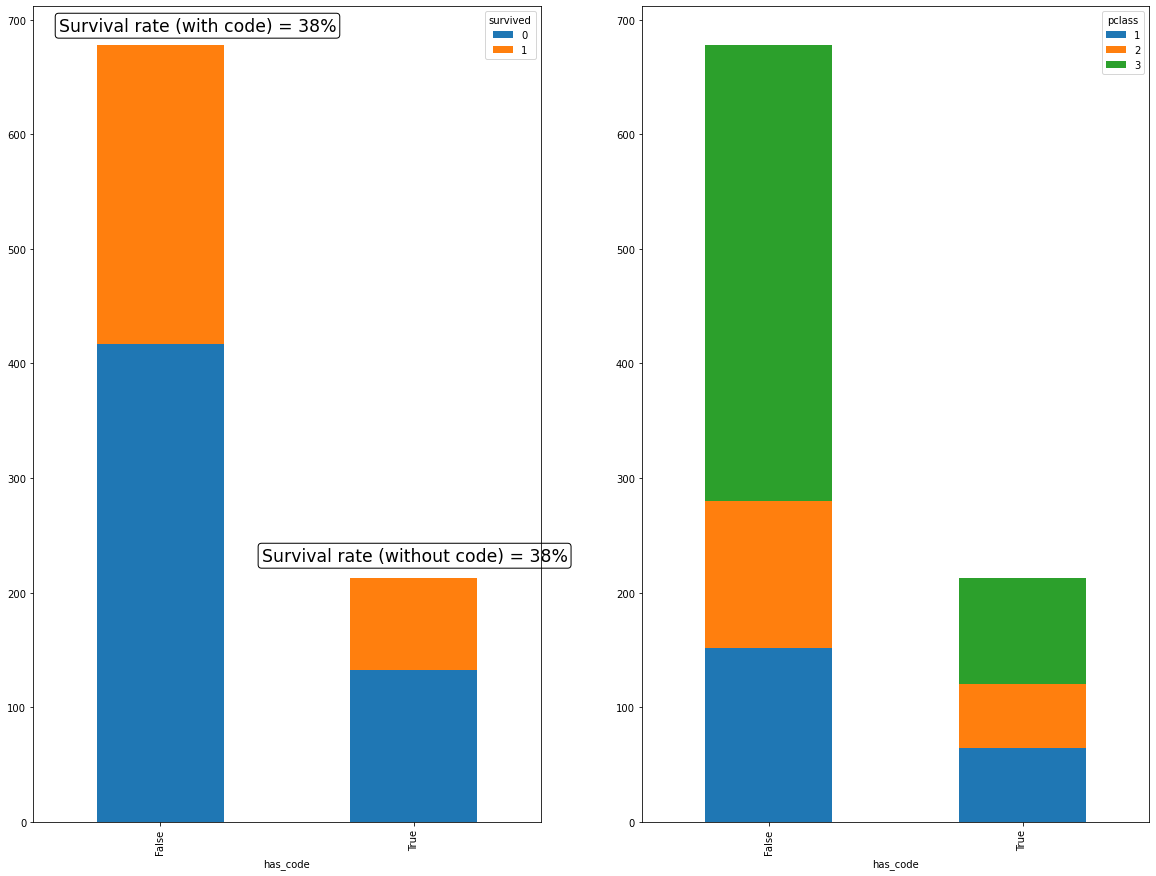

In [23]:
# create a figure
fig = plt.figure(figsize = (20, 15))

# create a grid inside the figure
gs = fig.add_gridspec(1, 2)

# create an empty list
ax = [None for _ in range(5)]

# find survival rate between groups
has_code_total = train_copy[train_copy['has_code'] == True].passengerid.count()
has_code_survived = train_copy[(train_copy['has_code'] == True) & (train_copy['survived'] == True)].passengerid.count()
has_code_surv_rate = round(has_code_survived/has_code_total * 100)

no_code_total = train_copy[train_copy['has_code'] == False].passengerid.count()
no_code_survived = train_copy[(train_copy['has_code'] == False) & (train_copy['survived'] == True)].passengerid.count()
no_code_surv_rate = round(no_code_survived/no_code_total * 100)

ax[0] = fig.add_subplot(gs[0, 0])
train_copy.groupby(['has_code', 'survived']).passengerid.count().unstack().plot(kind = 'bar', stacked = True, ax = ax[0])
ax[0].annotate(
    text = 'Survival rate (with code) = {}%'.format(has_code_surv_rate),
    xy = (0.05, 0.97), 
    xycoords = 'axes fraction',
    fontsize = 'xx-large',
    bbox = dict(facecolor = 'none', boxstyle = 'round, pad = 0.2', edgecolor = 'black')
)
ax[0].annotate(
    text = 'Survival rate (without code) = {}%'.format(no_code_surv_rate),
    xy = (0.45, 0.32), 
    xycoords = 'axes fraction',
    fontsize = 'xx-large',
    bbox = dict(facecolor = 'none', boxstyle = 'round, pad = 0.2', edgecolor = 'black')
)


ax[1] = fig.add_subplot(gs[0, 1])
train_copy.groupby(['has_code', 'pclass']).passengerid.count().unstack().plot(kind = 'bar', stacked = True, ax = ax[1])

# ax[2] = fig.add_subplot(gs[1, 0])
# train_copy.groupby(['has_code', 'age']).passengerid.count().unstack().plot(kind = 'bar', stacked = True, ax = ax[1])

In [24]:
train_copy[train_copy['ticket_number'] == 'STON/O']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,...,embarked,title,title_group,age_group,family_size,solo,ticket_split,ticket_code,ticket_number,has_code


In [25]:
# ticket code value counts
print(train_copy['ticket_code'].value_counts())
print('*'*100)
print(train_copy['ticket_number'].value_counts())

NA            678
PC             60
C.A.           27
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
F.C.C.          5
C               5
SC/PARIS        5
S.O.C.          5
SC/Paris        4
A/4.            3
S.O./P.P.       3
PP              3
A/4             3
P/PP            2
S.C./PARIS      2
SOTON/O2        2
SC/AH           2
A.5.            2
WE/P            2
A./5.           2
A/S             1
SO/C            1
F.C.            1
S.W./PP         1
SW/PP           1
SC              1
SCO/W           1
W/C             1
Fa              1
S.O.P.          1
S.C./A.4.       1
A4.             1
W.E.P.          1
S.P.            1
C.A./SOTON      1
Name: ticket_code, dtype: int64
****************************************************************************************************
1601       7
347082     7
2343       7
3101295    6
2144       6
          ..
9234       1
19988      1
2693   

# Model building

To keep things simple for now, we will build a simple maching learning model with the few features we've looked at so far.

The only concerns I have are that some of these features are correlated with one another. As we've seen, age is linked with the number of siblings/spouses and parents/children one has. How should this be dealt with? 

In the meantime, we will use the following features:

- Pclass
    - no further pre-processing required
- Sex
    - needs to be converted to numerical
- Age
    - no pre-processing required

## Pre-processing

- Do train test split here for extra validation dataset.
- Add method so that .get_feature_names_out works from ColumnTransformer

In [68]:
# split the target variable
train_y = train['survived']
train_X = train.drop(columns = 'survived')
train_copy = train_X.copy()

In [69]:
# build class to filter attributes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline

class AgeGroupAdder(BaseEstimator, TransformerMixin):
    
    '''Class to build age groups from age data'''
    
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        # creating age groups from age column
        age_intervals = (0, 7, 16, 30, 50, 100)
        age_groups = np.digitize(x = X.reshape(-1), 
                            bins = age_intervals).reshape(-1, 1)        
                
        # one hot encode age_group
        age_encoder = OneHotEncoder(sparse = False)
        age_encoded = age_encoder.fit_transform(pd.DataFrame(age_groups))
                        
        return age_encoded
    
class FamilyFeatureAdder(BaseEstimator, TransformerMixin):
    '''Class to calculate family size using the original parch and sibsp columns in the data.'''
    
    def __init__(self, solo_feature = False):
        
        self.solo_feature = solo_feature
        return None 
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        
        # see if solo_feature is switched on
        if self.solo_feature == False:
            
            # create family size feature
            family_size = X.sum(axis = 1).to_numpy().reshape(-1, 1)
            
            return family_size
        
        elif self.solo_feature == True:
            
            # create family size feature
            family_size = X.sum(axis = 1)
            
            # create solo feature
            solo = family_size == 0
            solo = solo.map(arg = {False: 0, True: 1}).to_numpy().reshape(-1, 1)
            
            return solo

class TitleGroupAdder(BaseEstimator, TransformerMixin):
    ''' Class to build the title group feature.'''
    
    def __init__(self):
        
        return None
    
    def fit(self, X, y= None):
        
        return self
    
    def transform(self, X):
                
        # get title
        titles= X['name'].str.split(pat = ',').apply(lambda x: x[1].split('.')[0])
        
        # build title group feature
        title_group = titles
        title_group.replace(to_replace = [' Miss', ' Mlle'], value = 'Unmarried female', inplace = True)
        title_group.replace(to_replace = [' Mrs', ' Mme'], value = 'Married female', inplace = True)
        title_group.replace(to_replace = [' Master', ' Dr', ' Rev', ' Major', ' Col', ' Don', ' Ms', 
                                                    ' Lady', ' Sir', ' Capt', ' the Countess', ' Jonkheer', ' Dona'], 
                                                      value = 'Rare', inplace = True)
            
        return title_group.to_numpy().reshape(-1, 1)

In [74]:
# create sequential steps for creating the age_group feature using Pipeline
age_pipe = Pipeline(steps = [('age_imputer', SimpleImputer()),
                           ('age_group_adder', AgeGroupAdder())])
title_pipe = Pipeline(steps = [('title_adder', TitleGroupAdder()),
                               ('title_ohe', OneHotEncoder(sparse = False))])

# state steps which will transform simultaneously (apart from within age_pipe)
ct = ColumnTransformer(transformers = [ 
        ('pclass_passthrough', 'passthrough', ['pclass']),
        ('age_feature', age_pipe, ['age']),
        ('sex_ohe', OneHotEncoder(), ['sex']),
        ('family_feature', FamilyFeatureAdder(solo_feature = False), ['parch', 'sibsp']),
        ('title_feature', title_pipe, ['name'])
    ], remainder='drop'
)

In [76]:
# test column transformer
train_prepared = ct.fit_transform(train_copy)
print(pd.DataFrame(train_prepared))

      0    1    2    3    4    5    6    7    8    9    10   11   12
0    3.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
1    1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0
2    3.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0
3    1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0
4    3.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
886  2.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
887  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0
888  3.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  3.0  0.0  0.0  0.0  1.0
889  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
890  3.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0

[891 rows x 13 columns]


## Building model pipeline

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# suppress warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

### *Option 1 - find the most optimal classifier!*

This method attempts to find one single classifier to make predictions.

In [166]:
### CLASSIFIERS ###
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
svc = SVC()
sgd = SGDClassifier()
knn = KNeighborsClassifier()

### HYPERPARAMETERS ###
params_log_reg = {
     'preprocessor__family_feature__solo_feature': [True, False],
     'classifier': [log_reg],
     'classifier__max_iter': [50, 100, 1000, 10000],
     'classifier__penalty': ['none', 'l2'],
     'classifier__C': [0.1, 1, 2, 5, 10, 20, 100]
}
params_random_forest = {
     'preprocessor__family_feature__solo_feature': [True, False],
     'classifier': [random_forest],
     'classifier__n_estimators': [10, 100, 200, 1000]
}
params_svc = {
    'preprocessor__family_feature__solo_feature': [True, False],
    'classifier': [svc],
    'classifier__C': [0.1, 1, 2, 5, 10, 20, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__degree': [1, 2, 3, 4, 5],
    'classifier__max_iter': [50, 100, 1000, 10000],
    'classifier__probability': [True]
}
params_sgd = {
    'preprocessor__family_feature__solo_feature': [True, False],
    'classifier': [sgd],
    'classifier__loss': ['hinge', 'log', 'modified_huber',
                         'squared_hinge', 'perceptron'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': [50, 100, 1000, 10000],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__eta0': [0.0001, 0.001, 0.01, 0.1]
}
params_knn = {
    'preprocessor__family_feature__solo_feature': [True, False],
    'classifier': [knn],
    'classifier__n_neighbors': [3, 4, 5, 7, 10],
    'classifier__weights': ['uniform', 'distance']
}
params = [params_log_reg, params_random_forest, 
          params_svc, params_sgd, params_knn]

### CREATING PIPELINE ###
pipeline = Pipeline(steps = [('preprocessor', ct), ('classifier', log_reg)])
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 45)

### GRID SEARCH ###
gs = GridSearchCV(estimator= pipeline,
                  param_grid= params,
                  cv = cv,
                  scoring = 'accuracy',
                  error_score = 'raise')

gs.fit(train_X, train_y)

### GET BEST CLASSIFIER + PARAMETERS ###
print('Accuracy is:', gs.best_score_)
print('Best parameters are:', gs.best_params_)
estimator = gs.best_params_['classifier']

# export results
pd.DataFrame(gs.cv_results_).to_csv('cross_validation_results.csv')

Accuracy is: 0.8327537505492435
Best parameters are: {'classifier': SVC(C=1, degree=1, max_iter=1000, probability=True), 'classifier__C': 1, 'classifier__degree': 1, 'classifier__kernel': 'rbf', 'classifier__max_iter': 1000, 'classifier__probability': True, 'preprocessor__family_feature__solo_feature': False}


### *Option 2 - ensemble ML*

This methods attempts to find multiple skilled classifiers which then vote towards a prediction.

In [114]:
### CLASSIFIERS ###
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
svc = SVC()
sgd = SGDClassifier()
knn = KNeighborsClassifier()

classifiers = {
    'log_reg': log_reg,
    'random_forest': random_forest, 
    'svc': svc,
    'sgd': sgd,
    'knn': knn
}

### HYPERPARAMETERS ###
params = {
     'log_reg':{
     'max_iter': [50, 100, 1000, 10000],
     'penalty': ['none', 'l2'],
     'C': [0.1, 1, 2, 5, 10, 20, 100]
    },
     'random_forest':{
     'n_estimators': [10, 100, 200, 1000]
    },
    'svc':{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5],
    'max_iter': [50, 100, 1000, 10000],
    'probability': [True]
    },
    'sgd':{
    'loss': ['log', 'modified_huber',
                         'squared_hinge', 'perceptron'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 1000, 10000],
    'learning_rate': ['constant', 'adaptive'],
    'eta0': [0.0001, 0.001, 0.01, 0.1],
    },
    'knn':{
    'n_neighbors': [3, 4, 5, 7, 10],
    'weights': ['uniform', 'distance']
    }
}

# record scores and parameters
best_score = dict()
best_clfs = dict()

for clf_key in list(classifiers.keys()):
        
    # get classifier and params
    clf = classifiers[clf_key]
    clf_params = params[clf_key]
    
    # grid search
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 45)
    gs = GridSearchCV(estimator=clf, 
                      param_grid=clf_params,
                      scoring = 'accuracy',
                      error_score = 'raise')
    
    # fit
    gs.fit(train_prepared, train_y)
    
    best_score[clf_key] = gs.best_score_
    best_clfs[clf_key] = gs.best_estimator_

print(best_score)
print('*'*50)
print(best_clfs)

{'log_reg': 0.8148201619484026, 'random_forest': 0.8170924612390935, 'svc': 0.8316364321134895, 'sgd': 0.8193082669010107, 'knn': 0.8282781997363632}
**************************************************
{'log_reg': LogisticRegression(C=1, max_iter=50), 'random_forest': RandomForestClassifier(n_estimators=1000), 'svc': SVC(degree=1, max_iter=1000, probability=True), 'sgd': SGDClassifier(alpha=0.001, eta0=0.01, learning_rate='constant', loss='log'), 'knn': KNeighborsClassifier(n_neighbors=4)}


In [123]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

classifiers = list(best_clfs.items())

vote_clf = VotingClassifier(estimators = classifiers, voting = 'hard')

clf_pipeline = Pipeline(steps = [
    ('preprocessor', ct),
    ('vote_clf', vote_clf)
])

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 45)
cv_scores = cross_val_score(estimator=clf_pipeline,
                            X=train_X,
                            y=train_y,
                            scoring='accuracy',
                            cv=cv)


print(cv_scores)

clf_pipeline.fit(train_X, train_y)

[0.84357542 0.83707865 0.74719101 0.83707865 0.87078652]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pclass_passthrough',
                                                  'passthrough', ['pclass']),
                                                 ('age_feature',
                                                  Pipeline(steps=[('age_imputer',
                                                                   SimpleImputer()),
                                                                  ('age_group_adder',
                                                                   AgeGroupAdder())]),
                                                  ['age']),
                                                 ('sex_ohe', OneHotEncoder(),
                                                  ['sex']),
                                                 ('family_feature',
                                                  FamilyFeatureAdder(),
                                                  ['parch', 'sibsp']),
   

In [124]:
# look at examples
num_examples = 20
some_data = train_X[:num_examples]
example_preds = clf_pipeline.predict(some_data)

print('Predictions for first {} passengers are:'.format(num_examples), example_preds)
print('True labels for first {} passengers are:'.format(num_examples), train_y[:num_examples].to_numpy())

Predictions for first 20 passengers are: [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1]
True labels for first 20 passengers are: [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1]


# Model evaluation

## Precision & Recall vs Threshold value

We have a working model. By default it is using a threshold of 0.5. If we want to, we can tune this to achieve a particular scoring aim. For example, do we want to catch more positive classes at the cost of being less precise? Or the other way around? If so, we will need to see how different thresholds affect precision and recall. This is shown below.

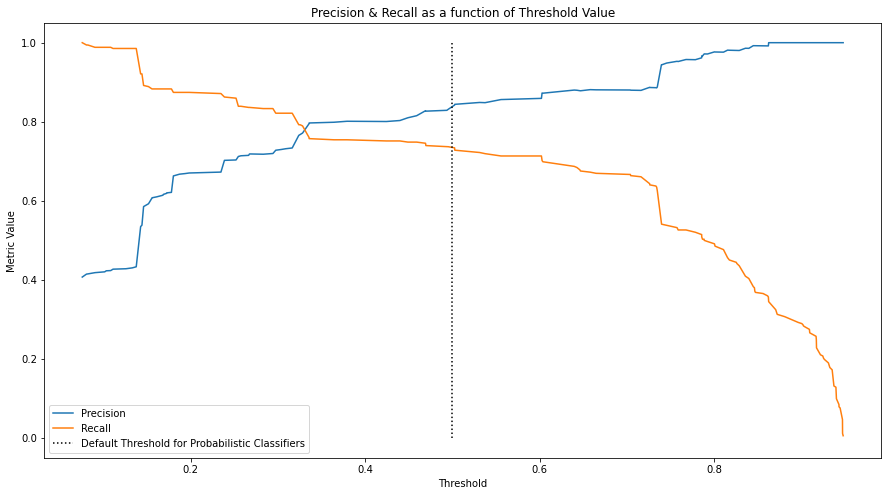

In [117]:
# make predictions on the training set
train_preds = clf_pipeline.predict_proba(train_X)[:,1]

# get metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(train_y, train_preds)

# plot threshold vs precision
figure, axes = plt.subplots(figsize = (15, 8))
sns.lineplot(x = thresholds, y = precision[:-1], dashes = True, label = 'Precision', axes = axes)
sns.lineplot(x = thresholds, y = recall[:-1], dashes = True, label = 'Recall', axes = axes)
axes.set_title('Precision & Recall as a function of Threshold Value')
axes.set_xlabel('Threshold')
axes.set_ylabel('Metric Value')
axes.vlines(x = 0.5, ymin = 0, ymax = 1, colors = 'black', linestyles = 'dotted', label = 'Default Threshold for Probabilistic Classifiers')
axes.legend()

## ROC curve

The Receiver Operating Characteristic curve plots the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of the positive class which is predicted as positive. The false positive rate is the proportion of the negative class which is predicted as positive. Both these rates should rise if the threshold value falls and vice versa. Ideally, we would have a 100% TPR and a 0% FPR, however, this is not ideal. 

For example, if we have a low threshold value, we are less precise with our positive predictions. We therefore make more positive predictions. This means that the TPR rises. It also means we make more mistakes as more of our positive predictions are not correct. This means the FPR also rises. 

Our aim is to maximise the TPR rate whilst minimising the FPR. An ideal/optimal point on the ROC curve would be the top left of the graph.

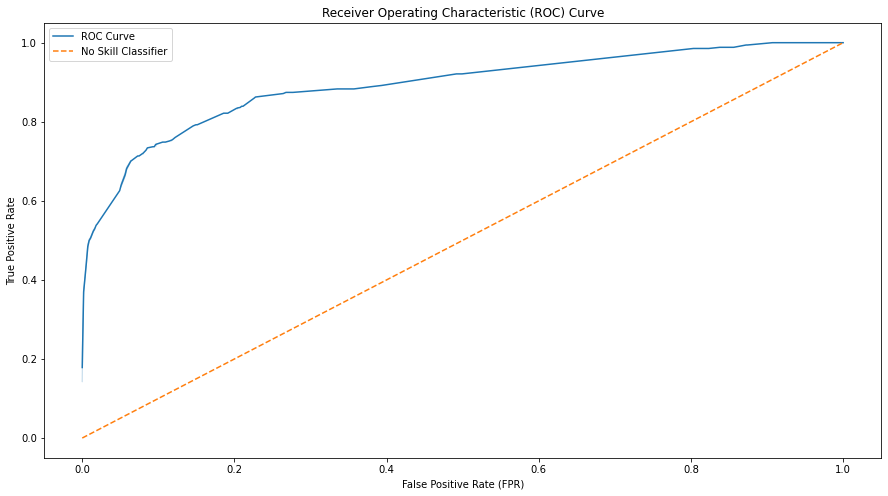

In [118]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train_y, train_preds)

# plot threshold vs precision
no_skill_x = np.arange(0, 1, 0.001)
no_skill_y = np.arange(0, 1, 0.001)

figure, axes = plt.subplots(figsize = (15, 8))
sns.lineplot(x = fpr, y = tpr, dashes = True, label = 'ROC Curve', axes = axes)
axes.set_title('Receiver Operating Characteristic (ROC) Curve')
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate')
sns.lineplot(x = no_skill_x, y = no_skill_y, linestyle = '--', label = 'No Skill Classifier')
axes.legend()

# Submit predictions on test set

In [125]:
make_submission = True
message = 'Implemented voting classifier with multiple algorithms (hard voting)'

if make_submission == True:
    
    # # preprocess test set
    # processor_test = PreProcessor(feature_dict = feature_dict)
    # test_prepared, ohe_columns = processor_test.fit_transform(test)

    # make predictions
    preds_test = clf_pipeline.predict(test)

    # put submission together
    submission = np.c_[test['passengerid'].to_numpy(), preds_test]
    submission_pandas = pd.DataFrame(submission[:,1], index = submission[:,0], columns = ['Survived'])
    submission_pandas.index.name = 'PassengerId'
    submission_pandas.to_csv('submission.csv')

    # submit predictions
    api.competition_submit(file_name = 'submission.csv', message = message, competition = 'titanic')

    # see results
    !kaggle competitions submissions titanic
else:
    
    # see previous results
    !kaggle competitions submissions titanic

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 1.81kB/s]


fileName               date                 description                                                           status    publicScore  privateScore  
---------------------  -------------------  --------------------------------------------------------------------  --------  -----------  ------------  
submission.csv         2022-11-19 23:47:38  Implemented voting classifier with multiple algorithms (hard voting)  pending                              
submission.csv         2022-11-19 23:45:17  Implemented voting classifier with multiple algorithms                complete  0.78229                    
submission.csv         2022-11-19 16:07:24  Added SVC algorithm                                                   complete  0.78229                    
submission.csv         2022-11-17 23:22:19  Added title group feature                                             complete  0.77990                    
submission.csv         2022-11-11 17:44:25  Added solo feature                          